## Predicting Loan Defaults


In [106]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.naive_bayes import MultinomialNB, CategoricalNB
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np


dfo = pd.read_csv("/Users/samuelescarfone/Desktop/Dat 300/project1/Predicting-Credit-Card-Defaults/data/Loan_default.csv", header=0)
dfo.head(5)


,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0


#### Cleaning & Preparing the Data

In [107]:
target = 'Default'
print(dfo.isnull().sum())

LoanID            0
Age               0
Income            0
LoanAmount        0
CreditScore       0
MonthsEmployed    0
NumCreditLines    0
InterestRate      0
LoanTerm          0
DTIRatio          0
Education         0
EmploymentType    0
MaritalStatus     0
HasMortgage       0
HasDependents     0
LoanPurpose       0
HasCoSigner       0
Default           0
dtype: int64


In [108]:
corr = dfo.corr(numeric_only=True)
corr.head(10)
corr_with_default = corr['Default'].sort_values(ascending=False)

uniqueRows = dfo.nunique().sort_values(ascending=False)
print("Unique values per column:")
print(uniqueRows)




Unique values per column:
LoanID            255347
LoanAmount        158729
Income            114620
InterestRate        2301
CreditScore          550
MonthsEmployed       120
DTIRatio              81
Age                   52
LoanTerm               5
LoanPurpose            5
NumCreditLines         4
Education              4
EmploymentType         4
MaritalStatus          3
HasMortgage            2
HasDependents          2
HasCoSigner            2
Default                2
dtype: int64


In [109]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

#Encoding not necessary for Naive Bayes, but we will need it for later models
for col in dfo.columns:
    if dfo[col].dtype == 'object':
        dfo[col] = le.fit_transform(dfo[col])

df = dfo.drop(columns=['LoanID','Age'])

df.dropna(inplace=True)

In [110]:
df.head(5)

,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,85994,50587,520,80,4,15.23,36,0.44,0,0,0,1,1,4,1,0
1,50432,124440,458,15,1,4.81,60,0.68,2,0,1,0,0,4,1,0
2,84208,129188,451,26,3,21.17,24,0.31,2,3,0,1,1,0,0,1
3,31713,44799,743,0,3,7.07,24,0.23,1,0,1,0,0,1,0,0
4,20437,9139,633,8,4,6.51,48,0.73,0,3,0,0,1,0,0,0


In [111]:
df[target].value_counts()

Default
0    225694
1     29653
Name: count, dtype: int64

In [112]:
df.describe()

,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
count,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000
mean,82499.304597,127578.865512,574.264346,59.541976,2.501036,13.492773,36.025894,0.500212,1.494421,1.500096,0.999918,0.500014,0.500268,2.000501,0.500108,0.116128
std,38963.013729,70840.706142,158.903867,34.643376,1.117018,6.636443,16.969330,0.230917,1.118826,1.117358,0.816051,0.500001,0.500001,1.412723,0.500001,0.320379
min,15000.000000,5000.000000,300.000000,0.000000,1.000000,2.000000,12.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48825.500000,66156.000000,437.000000,30.000000,2.000000,7.770000,24.000000,0.300000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,82466.000000,127556.000000,574.000000,60.000000,2.000000,13.460000,36.000000,0.500000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,0.000000
75%,116219.000000,188985.000000,712.000000,90.000000,3.000000,19.250000,48.000000,0.700000,2.000000,2.000000,2.000000,1.000000,1.000000,3.000000,1.000000,0.000000
max,149999.000000,249999.000000,849.000000,119.000000,4.000000,25.000000,60.000000,0.900000,3.000000,3.000000,2.000000,1.000000,1.000000,4.000000,1.000000,1.000000


# Lets start by doing a simple statistical model - Naive Bayes

#### Randomize Data and Split into Train and Test Sets

In [113]:
np.random.seed(1234)
randomize_data = df.sample(frac=1) 
size = int(0.8 * len(randomize_data))
train = randomize_data[:size].reset_index(drop=True)
test = randomize_data[size:].reset_index(drop=True)
print("Training shape:", train.shape)
print("Testing shape:", test.shape)


Training shape: (204277, 16)
Testing shape: (51070, 16)


In [114]:
trainX = train.iloc[:,:-1]
trainX = train.drop(columns=[target])
trainY = train[target]
colnames = trainX.columns

trainX.head(5)


,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner
0,96809,44706,618,34,4,21.93,48,0.85,2,1,2,1,1,1,0
1,79687,224131,809,40,2,11.95,36,0.64,0,2,0,0,1,1,0
2,66216,74977,385,82,4,12.72,48,0.79,1,0,2,1,1,3,1
3,47620,21367,378,119,2,24.97,48,0.77,2,2,1,0,0,1,0
4,98140,239788,301,116,1,12.49,12,0.87,0,2,0,0,1,1,1


In [115]:
testX = test.iloc[:, :-1]
testX = test.drop(columns=[target])

testY = test[target]


In [116]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
trainBrnli = le.fit_transform(trainY)

trainBrnli[:5]

array([0, 0, 0, 1, 0])

#### Run Model on Training Data

In [117]:
from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder()
trainX = enc.fit_transform(trainX)  
trainX = pd.DataFrame(trainX, columns=colnames)

trainX.head() 

,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner
0,63743.0,22626.0,318.0,34.0,3.0,1993.0,3.0,75.0,2.0,1.0,2.0,1.0,1.0,1.0,0.0
1,50383.0,124043.0,509.0,40.0,1.0,995.0,2.0,54.0,0.0,2.0,0.0,0.0,1.0,1.0,0.0
2,39879.0,39786.0,85.0,82.0,3.0,1072.0,3.0,69.0,1.0,0.0,2.0,1.0,1.0,3.0,1.0
3,25435.0,9296.0,78.0,119.0,1.0,2297.0,3.0,67.0,2.0,2.0,1.0,0.0,0.0,1.0,0.0
4,64767.0,132917.0,1.0,116.0,0.0,1049.0,0.0,77.0,0.0,2.0,0.0,0.0,1.0,1.0,1.0


In [118]:
model = CategoricalNB()
model.fit(trainX,trainBrnli) 

CategoricalNB()

In [119]:
yhattrain = model.predict(trainX)

In [120]:
pd.crosstab(yhattrain, trainY)

Default,0,1
row_0,,
0,180284,11261
1,205,12527


In [121]:
print("Accuracy: ", str(accuracy_score(yhattrain, trainBrnli)*100) + "%")

Accuracy:  94.3870332930286%


### Model Performance on Test Data

In [122]:
print("testX shape:", testX.shape)
print("trainX shape:", trainX.shape)

testX shape: (51070, 15)
trainX shape: (204277, 15)


In [123]:
testBrnli = le.fit_transform(testY)

testX = enc.fit_transform(testX) 
testX = pd.DataFrame(testX,columns=colnames) 
testX = pd.DataFrame(testX,columns=colnames) 
yhattest = model.predict(testX)

In [124]:
acc = accuracy_score(yhattest, testBrnli)
print("Accuracy: "+str(acc*100)+"%")

Accuracy: 87.06481300176229%


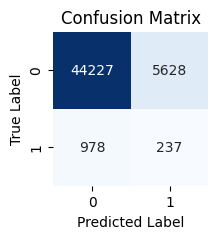

In [125]:
import seaborn as sns
confM =confusion_matrix(yhattest,testBrnli)
plt.figure(figsize=(2,2))
sns.heatmap(confM, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [126]:
pd.crosstab(yhattest, testY)
FNR  = confM[0,1] /(confM[1,1]+confM[0,1])
print(FNR)

0.9595907928388747


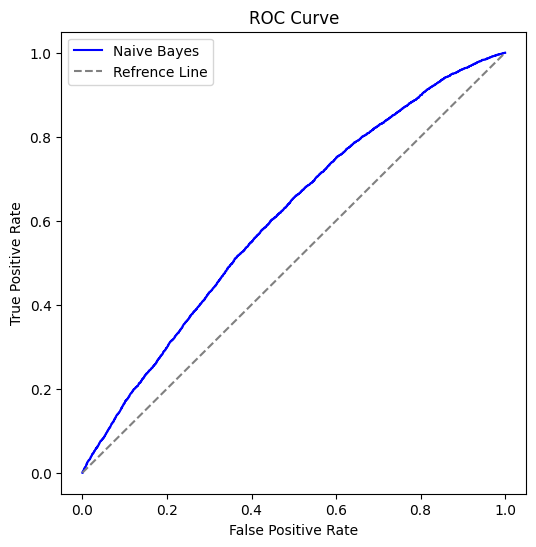

In [127]:
from sklearn.metrics import roc_curve

yProb = model.predict_proba(testX)[:,1]
f,t,thresh = roc_curve(testBrnli, yProb)

plt.figure(figsize=(6,6))
plt.plot(f,t,color='blue',label='Naive Bayes')
plt.plot([0,1],[0,1],color='gray', linestyle='--', label='Refrence Line')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()



### Light GBM Approach

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report


classifer = ra

[LightGBM] [Info] Number of positive: 23788, number of negative: 180489
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001737 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1251
[LightGBM] [Info] Number of data points in the train set: 204277, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116450 -> initscore=-2.026489
[LightGBM] [Info] Start training from score -2.026489


LGBMClassifier(colsample_bytree=0.9, learning_rate=0.02, metric='auc',
               n_estimators=2000, num_leaves=63, objective='binary',
               reg_lambda=1.0, scale_pos_weight=7.587397006894232,
               subsample=0.9)

In [134]:
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report

y_pred = model.predict(testX)
y_prob = model.predict_proba(testX)[:, 1]

print("Accuracy:", accuracy_score(testY, y_pred))
print("AUC:", roc_auc_score(testY, y_prob))
print("\nConfusion Matrix:\n", confusion_matrix(testY, y_pred))
print("\nClassification Report:\n", classification_report(testY, y_pred))

Accuracy: 0.7866653612688467
AUC: 0.6776101369408076

Confusion Matrix:
 [[38006  7199]
 [ 3696  2169]]

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.84      0.87     45205
           1       0.23      0.37      0.28      5865

    accuracy                           0.79     51070
   macro avg       0.57      0.61      0.58     51070
weighted avg       0.83      0.79      0.81     51070

